# FEniCS Demos

### Matt Hennessy

# Recap of last week...

### Steps needed when using FEM

* Derive the weak form of the problem
* Create a mesh for the domain
* Choose finite elements (cell geometry + basis functions)
* Assemble the equations locally and then globally
* Solve!


# What is (and isn't) FEnICS?

An open-source Python/C++ library for solving ODEs and PDEs using finite elements
* Very high level
* Parallelised
* Well maintained, lots of documentation, large user community

FEniCS is **not** a GUI-based program with pre-defined models like COMSOL or Abaqus

# Example 1 - Poisson's equation

Let's solve
\begin{align}
\nabla^2 u + f = 0 \quad &\text{in $\Omega$} \\
u = 0 \quad &\text{on $\partial \Omega$}
\end{align}

For simplicity, let's take $\Omega$ to be the unit square

# The weak form

Recall that the weak form is given by

\begin{align}
\underbrace{-\int_{\Omega} \nabla u \cdot \nabla v\, dx + \int_{\Omega} f v\, dx}_F = 0 \quad \text{for all $v \in V_h$}
\end{align}


# FEniCS Code

In [1]:
from fenics import *
import matplotlib.pyplot as plt

N = 20
mesh = UnitSquareMesh(N, N)

P1 = FiniteElement('CG', 'triangle', 1)
Vh = FunctionSpace(mesh, P1)

u = Function(Vh)
v = TestFunction(Vh)

def boundaries(x):
    return near(x[0], 0) or near(x[0], 1) or near(x[1], 0) or near(x[1], 1)

bc = DirichletBC(Vh, 0.0, boundaries)

f = 1.0
F = -dot(grad(u), grad(v)) * dx + f * v * dx

solve(F == 0, u, bc)

# Outputs

0.0735267092333906


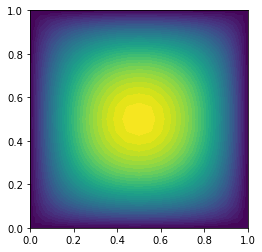

In [3]:
print(u(0.5, 0.5))
plot(u)

# Shape of a liquid drop

The shape of a liquid drop resting on a flat surface is given by
\begin{align}
\nabla \cdot \left(\frac{\nabla h}{\sqrt{1 + |\nabla h|^2}}\right) - B h + p = 0.
\end{align}

Here, $h(x,y)$ is the height of the drop at $(x,y)$, $B$ is the Bond number, and $p$ is the liquid pressure. 

We impose $h = 0$ when $x \in \partial \Omega$

# Weak form
The weak form is given by
\begin{align}
\int_{\Omega} \vec{n} \cdot \nabla v\, dx - \int_{\Omega} B h v\, d x + \int_{\Omega} p v\, dx = 0 \quad \text{for all $v \in V_h$}
\end{align}
where
\begin{align}
\vec{n} = -\frac{\nabla h}{\sqrt{1 + |\nabla h|^2}}
\end{align}

# FEniCS implementation

* The ```solve``` function can handle nonlinear problems (Newton's method)
* The Jacobian can be computed **analytically** using the ```derivative``` function
* The ```interpolate``` method can be used to create a non-zero initial guess

# FEniCS code

In [5]:
from fenics import *
import matplotlib.pyplot as plt
from timeit import default_timer as timer

# define the Bond number and drop pressure
B = Constant(1)
p = Constant(1)

# create a mesh for the unit square
N = 30
mesh = RectangleMesh(Point(0, 0), Point(1, 1), N, N)

# choose elements
P1 = FiniteElement('CG', 'triangle', 1)
Vh = FunctionSpace(mesh, P1)

# define boundaries and create h = 0 boundary condition
def boundaries(x):
    return near(x[0], 0) or near(x[0], 1) or near(x[1], 0) or near(x[1], 1)

bc = DirichletBC(Vh, 0.0, boundaries)

# create solution (h) and test function (v)
h = Function(Vh)
v = TestFunction(Vh)

# weak form and Jacobian
n = -grad(h) / sqrt(1 + dot(grad(h), grad(h)))
F = dot(n, grad(v)) * dx + p * v * dx - B * h * v * dx
J = derivative(F, h)

# initial guess
h_0 = Expression("x[0] * (1-x[0]) * x[1] * (1-x[1])", degree=1)
h.interpolate(h_0)

# create function to solve the problem and time the calculation
def solve_and_time():
    start = timer()
    solve(F == 0, h, bc, J = J)
    end = timer()
    print("Problem assembled and solved in", (end - start) * 1000, 'ms')

Problem assembled and solved in 3.0049079996388173 ms


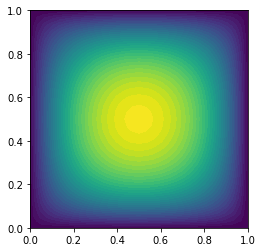

In [9]:
solve_and_time()
plot(h)

# If you want to customise the nonlinear solver...
* Use the ```NonlinearVariationalProblem``` class
* Can invoke the PETSC SNES solver
* Can choose the linear solver (e.g. MUMPS, GMRES, preconditioners, etc)

```python
problem = NonlinearVariationalProblem(F, X, bcs = bcs, J = J)
solver = NonlinearVariationalSolver(problem)

solver.parameters['nonlinear_solver'] = 'snes'
solver.parameters['snes_solver']['absolute_tolerance'] = 1e-8
solver.parameters['snes_solver']['linear_solver'] = 'mumps'
```

# Automatic derivation of the weak form

FEniCS can derive the weak form if the PDE can be 
obtained from minimisation of a functional

The total energy of the drop is
\begin{align}
E[h,\nabla h] = \int_{\Omega} \left(\sqrt{1 + |\nabla h|^2} - p h + \frac{B}{2}h^2\right)\, dx
\end{align}

The weak form can be obtained using the ```derivative``` function:
```python
E = (sqrt(1 + dot(grad(h), grad(h))) - p * h + B * h**2 / 2) * dx
F = derivative(E, h)
```

# What happens if $B \gg 1$?

* The Bond number is defined as $B = \rho g H / \gamma$
* $B \gg 1$ corresponds to a situation where gravity is very strong

Problem assembled and solved in 5.312493000019458 ms


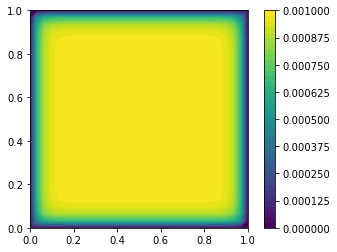

In [11]:
B.assign(1000)
solve_and_time()
fig = plot(h)
plt.colorbar(fig)

# Dealing with boundary layers

#### Use a fine mesh
* Computationally expensive
* Offset by using multiple CPUs
* FEniCS can be run in parallel using ```mpirun```

#### Using an adaptive mesh
* FEniCS can do a goal-based adaptive mesh refinement
* Implemented in the  ```AdaptiveNonlinearVariationalSolver``` class

# Stokes flow in a channel with a cylinder
<center>
<img width="500" src="flow.png">
</center>


The incompressible Stokes equations are given by
\begin{align}
\nabla \cdot \mathbf{T} &= 0, \\
\mathbf{T} &= \mu (\nabla \vec{u} + \nabla \vec{u}^T) - p \mathbf{I}, \\
\nabla\cdot \vec{u} &= 0.
\end{align}

The aim is to compute the force exerted on the cylinder by the fluid
\begin{align}
F = \int_{Cylinder} \vec{e}_z \cdot (\mathbf{T} \vec{n})\, ds
\end{align}

# Weak form

The weak form for this problem is
\begin{align}
\int_{\Omega} \mathbf{T}:\nabla \vec{v}\,dx = 0, \\
\int_{\Omega} (\nabla \cdot \vec{u}) q\,dx = 0,
\end{align}
where $\vec{v}$ and $q$ are test functions

# Meshing

* We will create a mesh for this problem using Gmsh
* This mesh will be loaded into Python and used by FEnICS
* The labels of boundaries will also be imported
* Makes it easy to apply boundary conditions

# Summary

* FEniCS has many features that make it well suited for research problems
* Relatively easy to implement complex models and perform complex calculations
* Functionality can be extended through external packages (mshr, meshio, multiphenics, FEniCSx)